In [8]:
!pip install -r ../requirements.txt


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:

import biosteam as bst
import pdb
import numpy as np
from scipy.optimize import differential_evolution # population based optimization code
from scipy.stats import qmc # latin hypercube sampling 



In [1]:

import matplotlib.pyplot as plt
import biosteam as bst
import pdb
import numpy as np
from scipy.optimize import differential_evolution # population based optimization code
from scipy.stats import qmc # latin hypercube sampling 
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
import warnings
from BayesianNN import *

class BlackBox():
    def __init__(self, verbose=False):
        bst.nbtutorial() # For light-mode diagrams, ignore warnings
        self.set_base_model()
        self.nEval = 0
        self.verbose = verbose
        self.history = []  # 최적화 과정 저장
        print(" ##### An instance of the 'BlackBox' class  has been initialised!")
    
    def set_base_model(self):
        # relevant values based on the website example
        # _n1 = 12 # number of stages for extractor
        # _Lr1, _Hr1, _k1  = [0.95, 0.95, 1.4]
        # _Lr2, _Hr2, _k2  = [0.999, 0.999, 1.4]
        # _T_hex = 310
        # _Lr3, _Hr3, _k3  = [0.99, 0.99, 1.5]
        X = [12, 0.95, 0.95, 0.999, 0.999,  310, 0.99, 0.99, ]
        self._set(X)
        
    def _bounds(self):
        # bounds for variables. feel free to change!
        bounds = [(0, 50), # no. of stages in extractor
                  (0, 0.9999), (0, 0.9999),  # light key, heavy key, 'k' for extract distiller
                  (0, 0.9999), (0, 0.9999),  # light key, heavy key, 'k' for acetic_acid_purification
                  (273, 350), # temperature for 'HX'
                  (0, 0.9999), (0, 0.9999),  # light key, heavy key, 'k' for reffinate_distiller
                  ]
        return bounds
    
    def _integrality(self):
        # which varibales are integers (True if integer)
        ints = [True, 
                False, False, 
                False, False, 
                False, 
                False, False, 
                ]
        return ints
        
        
    def _set(self, X):
        
        # Define chemicals used in the process
        bst.settings.set_thermo(['Water', 'AceticAcid', 'EthylAcetate'])

        
        _n1 = X[0] # number of stages for extractor
        _Lr1, _Hr1,   = X[1], X[2]
        _Lr2, _Hr2,   = X[3:5]
        _T_hex = X[5]
        _Lr3, _Hr3  = X[6:8]
        
        _k1, _k2, _k3 = (1.5, 1.5, 1.5)
        
        # print(_Lr2)
        # ensure that integer variables are in fact integer
        _n1 = int(_n1)
        
        
        
        # Amount of ethyl-acetate to fermentation broth
        solvent_feed_ratio = 1.5

        # Fermentation broth with dilute acetic acid
        acetic_acid_broth = bst.Stream(ID='acetic_acid_broth', AceticAcid=1000, Water=9000, units='kg/hr')

        # Solvent
        ethyl_acetate = bst.Stream(ID='ethyl_acetate',  EthylAcetate=1)

        # Products
        glacial_acetic_acid = bst.Stream(ID='glacial_acetic_acid')
        wastewater = bst.Stream(ID='wastewater')

        # Recycles
        solvent_recycle = bst.Stream('solvent_rich')
        water_rich = bst.Stream('water_rich')
        distillate = bst.Stream('raffinate_distillate')
        
        
        # System and unit operations
        with bst.System('AAsep') as sys:
            extractor = bst.MultiStageMixerSettlers(
                'extractor',
                ins=(acetic_acid_broth, ethyl_acetate, solvent_recycle),
                outs=('extract', 'raffinate'),
                top_chemical='EthylAcetate',
                feed_stages=(0, -1, -1),
                N_stages=_n1,
                use_cache=True,
            )

            @extractor.add_specification(run=True)
            def adjust_fresh_solvent_flow_rate():
                broth = acetic_acid_broth.F_mass
                EtAc_recycle = solvent_recycle.imass['EthylAcetate']
                EtAc_required = broth * solvent_feed_ratio
                if EtAc_required < EtAc_recycle:
                    solvent_recycle.F_mass *= EtAc_required / EtAc_recycle
                    EtAc_recycle = solvent_recycle.imass['EthylAcetate']
                EtAc_fresh = EtAc_required - EtAc_recycle
                ethyl_acetate.imass['EthylAcetate'] = max(
                    0, EtAc_fresh
                )

            HX = bst.HXutility(
                'extract_heater',
                ins=(extractor.extract),
                outs=('hot_extract'),
                rigorous=True,
                V=0,
            )
            ED = bst.ShortcutColumn(
                'extract_distiller',
                ins=HX-0,
                outs=['', 'acetic_acid'],
                LHK=('Water', 'AceticAcid'),
                Lr=_Lr1,
                Hr=_Hr1,
                k=_k1,
                partial_condenser=False,
            )
            ED2 = bst.ShortcutColumn(
                'acetic_acid_purification',
                ins=ED-1,
                outs=('', glacial_acetic_acid),
                LHK=('EthylAcetate', 'AceticAcid'),
                Lr=_Lr2,
                Hr=_Hr2,
                k=_k2,
                partial_condenser=False
            )
            ED.check_LHK = ED2.check_LHK = False
            mixer = bst.Mixer(
                ins=(ED-0, ED2-0, distillate)
            )
            HX = bst.HXutility(ins=mixer-0, T=_T_hex)
            settler = bst.MixerSettler(
                'settler',
                ins=HX-0,
                outs=(solvent_recycle, water_rich),
                top_chemical='EthylAcetate',
            )
            mixer = bst.Mixer(ins=[extractor.raffinate, water_rich])
            RD = bst.ShortcutColumn(
                'raffinate_distiller',
                LHK=('EthylAcetate', 'Water'),
                ins=mixer-0,
                outs=[distillate, wastewater],
                partial_condenser=False,
                Lr=_Lr3,
                Hr=_Hr3,
                k=_k3,
            )
            
        sys.operating_hours = 330 * 24 # annual operating hours, hr/yr
        
        self.sys = sys

    def capex(self):
        # capex of equipment in MMUSD/yr
        capex = round(self.sys.installed_equipment_cost / 1e6, 4)
        
        try:
            int(capex) # checks if nan or a number is returned
            return capex
        
        except:
            print(capex)
            print("capex error")
            return 10
        
    def opex(self):
        # opex of equipment in MMUSD/yr
        # opex = round(self.sys.material_cost + self.sys.utility_cost / 1e6, 4)
        opex = round((self.sys.material_cost + self.sys.utility_cost) / 1e6, 4)
        try:
            int(opex) # checks if nan or a number is returned
            return opex
        
        except:
            print("opex error")
            return 10
        
    def cost(self):
        return self.capex() + self.opex()
    
    def revenue(self):
        # price taken from website
        # https://businessanalytiq.com/procurementanalytics/index/acetic-acid-price-index/
        
        if self.acetic_acid_constraint() == 0: # return profit if in-specification
            stream = [stream for stream in self.sys.streams if stream.ID == 'glacial_acetic_acid'][0]
            P_AceticAcid = 0.4 # $/kg
            F_AceticAcid = stream.F_mass
            return round(P_AceticAcid * F_AceticAcid * self.sys.operating_hours / 1e6, 4) # Units: $/yr
        
        else: # return nothing if not in-specification
            print("revenue error")
            return 0
    
    def profit(self):
        return self.revenue() - self.cost()
            
    def MSP(self):
        stream = [stream for stream in self.sys.streams if stream.ID == 'glacial_acetic_acid'][0]
        P_AceticAcid = 0.4 # $/kg
        F_AceticAcid = stream.F_mass * self.sys.operating_hours / 1e6 # kg/yr

        constraint_violation = self.acetic_acid_constraint()  # 제약 위반 정도 (0이면 만족, 클수록 심각한 위반)
    
        if constraint_violation != 0: # return profit if in-specification
            # 제약 위반 → 패널티 적용 (순도 부족 정도에 따라 패널티 크기 조정)
            print('MSP penalty: constraint_violation')
            penalty_factor = 1 + 10 * constraint_violation  # (예: 순도 부족 1% -> 10배 패널티, 5% 부족 -> 50배 패널티)
            return round(self.cost() / F_AceticAcid * penalty_factor, 4)
        else:
            msp = self.cost() / F_AceticAcid # UNits: $/kg
            return round(msp, 4) 
        
    def simulate(self):
        self.nEval += 1
        self.sys.simulate()

    def wt_acetic_acid(self):
        stream = [stream for stream in self.sys.streams if stream.ID == 'glacial_acetic_acid'][0]
        return stream.get_mass_fraction(IDs='AceticAcid')
        
    def acetic_acid_constraint(self):
        x_desired = 0.98 # wt%
        x_achieved = self.wt_acetic_acid()
        d_x = x_desired - x_achieved # -ve if  product is in-spec
        
        cons = max(0, d_x) # return 0 if happy or constraint violation if not
        print(x_achieved, cons)
        return cons
        
    def func(self, X=None):
        
        try:
            if X is None:
                self.set_base_model()
                
            else:# set and run the simulation
                self._set(X) # set the new operating parameters
                    
            self.simulate() # run the simulation
            
            # assess plant financials
            objective_function = self.MSP()
            
        # if failure for any reason, then reutrn a value of np.inf
        except:
            print('func error')
            return np.inf


        if self.verbose:
            print(self.nEval, objective_function)
            
        return objective_function
    
    def natural_units(self, X):
        X_natural = np.zeros((np.shape(X)))
        bounds = self._bounds()
        b = np.array(bounds)
        d_b = b[:,1] - b[:,0] # range of bounds in natural units
        
        for i, x in enumerate(X):
            X_natural[i] = b[:,0] + (x[:] * d_b)
        
        return X_natural
            
    def optimize(self, method='DE', maxiter=50):
        
        # simple differential evolution approach based on scipy implementation 
        if method == 'DE':
            bounds = self._bounds()
            sampler = qmc.LatinHypercube(d=len(bounds))
            sample = sampler.random(n=50) # n is the population size!
            population = self.natural_units(sample)
            def callback(xk, convergence):
                """
                실행 횟수 (nEval)와 MSP 값 저장
                """
                self.nEval += 1  # 실행 횟수 증가
                msp_value = self.func(xk)  # 현재 MSP 계산
                self.history.append([self.nEval, msp_value])  # 실행 횟수와 MSP 저장

                if self.verbose:
                    print(f"Iteration {self.nEval}: MSP = {msp_value}")
            result = differential_evolution(
                self.func,
                bounds=self._bounds(),
                integrality=self._integrality(),
                init=sample,
                maxiter=maxiter,  # 최대 반복 횟수 설정
                callback=callback,  # 실행 결과 저장
            )

            return result
        elif method == 'BO':  # Bayesian Optimization (Gaussian Process)
            print("Running Bayesian Optimization (BO)")
    
            # Search Space 정의 (정수형 & 실수형 혼합)
            space = [
                Integer(0, 50, name="n_stages"),  # Extractor의 단계 수
                Real(0, 0.9999, name="Lr1"),
                Real(0, 0.9999, name="Hr1"),
                Real(0, 0.9999, name="Lr2"),
                Real(0, 0.9999, name="Hr2"),
                Real(273, 350, name="T_hex"),
                Real(0, 0.9999, name="Lr3"),
                Real(0, 0.9999, name="Hr3"),
            ]
            def objective(x):
                """
                Bayesian Optimization을 위한 목적 함수
                x: 리스트 형태의 입력 변수
                """
                # 여기서 nEval 증가 방식 변경 (현재 카운트 가져오기)
                eval_num = len(self.history) + 1  # 실제 호출 횟수를 기반으로 nEval 설정
                msp_value = self.func(x)
            
                # 최적화 과정 저장
                self.history.append([eval_num, msp_value])
            
                if self.verbose:
                    print(f"Iteration {eval_num}: MSP = {msp_value}")
            
                return msp_value  # MSP 값을 최소화하는 방향으로 최적화
    
            # Bayesian Optimization 실행
            result = gp_minimize(
                objective,  # 목적 함수
                dimensions=space,  # 탐색 공간
                n_calls=maxiter,  # 최대 반복 횟수
                random_state=42,  # 재현 가능성을 위한 난수 고정
                n_initial_points=10,  # 초기 샘플링 개수 (탐색 안정성 확보)
                acq_func="EI",  # Expected Improvement (EI) 사용
            )
            return result
        elif method == 'BNN':
            return self.active_learning_bnn(maxiter=maxiter, initial_samples=10)
    
    def active_learning_bnn(self, maxiter=20, initial_samples=10):
        """
        Bayesian Neural Network 기반 Active Learning을 사용하여 최적의 설계 변수 찾기
        """
        print("Running Bayesian Neural Network Active Learning")
    
        bounds = np.array(self._bounds())
        input_dim = len(bounds)
    
        #initial data sampling (Latin Hypercube Sampling)
        sampler = qmc.LatinHypercube(d=input_dim)
        sample = sampler.random(n=initial_samples)
        X_train = self.natural_units(sample)
        y_train = np.array([self.func(x) for x in X_train]).reshape(-1, 1)
    
        # PyTorch Tensor transformation
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    
        #inintialise model
        model = BayesianNN(input_dim)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()
    
        #initial training
        for epoch in range(100):
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
    
        #Active Learning 
        for i in range(maxiter):
            # 4.1 generate new sample (Latin Hypercube Sampling)
            new_samples = sampler.random(n=5)
            X_candidates = self.natural_units(new_samples)
    
            # 4.2 Using MC Dropoutto evaluate uncertainty
            model.train()  # Dropout 활성화
            X_candidates_tensor = torch.tensor(X_candidates, dtype=torch.float32)
    
            predictions = torch.stack([model(X_candidates_tensor) for _ in range(50)])  # 50번 샘플링
            uncertainties = predictions.std(dim=0).detach().numpy().flatten()
    
            # NaN 발생 여부 체크
            if np.isnan(uncertainties).any():
                print("Uncertainty contains NaN values!")
                
            # 4.3 select most uncertain data
            idx_max_uncertainty = np.argmax(uncertainties)
            X_new = X_candidates[idx_max_uncertainty]
    
            # 4.4 evaluate new data
            y_new = self.func(X_new)
            X_train = np.vstack([X_train, X_new])
            y_train = np.vstack([y_train, [y_new]])
    
            # PyTorch Tensor update
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    
            # 4.5 retrain the model!
            for epoch in range(50):
                optimizer.zero_grad()
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                loss.backward()
                optimizer.step()
    
            # 최적화 진행 과정 저장
            self.history.append([len(self.history) + 1, y_new])
    
            if self.verbose:
                print(f"Iteration {i + 1}: Selected Sample MSP = {y_new:.4f}, Uncertainty = {uncertainties[idx_max_uncertainty]:.4f}")
    
        return X_train, y_train
    
    def plot_results(self):
        """
        최적화 실행 횟수별 MSP 값 그래프 출력
        """
        if not self.history:
            print("No optimization history found. Run optimize() first.")
            return

        # 데이터를 numpy 배열로 변환
        history_array = np.array(self.history)  # [[nEval, MSP], [nEval, MSP], ...]
        iterations = history_array[:, 0]  # 실행 횟수
        msp_values = history_array[:, 1]  # MSP 값

        plt.figure(figsize=(8, 5))
        plt.plot(iterations, msp_values, marker='o', linestyle='-', color='b', label="MSP ($/kg)")
        plt.xlabel("Iteration (nEval)")
        plt.ylabel("MSP ($/kg)")
        plt.title("Optimization Progress (MSP over Iterations)")
        plt.grid(True)
        plt.legend()
        plt.show()
        





 ##### An instance of the 'BlackBox' class  has been initialised!
func error
func error
0.03573677502964603 0.944263224970354
MSP penalty: constraint_violation
1 1.434
0.02765034694934653 0.9523496530506534
MSP penalty: constraint_violation
nan
capex error
2 1.3472
0.0015959242279136895 0.9784040757720863
MSP penalty: constraint_violation
nan
capex error
3 1.7636
func error
0.038176770740442324 0.9418232292595576
MSP penalty: constraint_violation
4 0.9264
0.04139992958841701 0.938600070411583
MSP penalty: constraint_violation
5 0.3116
0.025337470530809807 0.9546625294691902
MSP penalty: constraint_violation
6 0.542
func error
func error
0.8298818557509409 0.15011814424905912
MSP penalty: constraint_violation
7 2.2365
0.080406703447459 0.8995932965525409
MSP penalty: constraint_violation
8 0.6299
func error
func error
0.03843766178481509 0.9415623382151849
MSP penalty: constraint_violation
9 2.9993
func error
0.002818967313660263 0.9771810326863397
MSP penalty: constraint_violation
nan


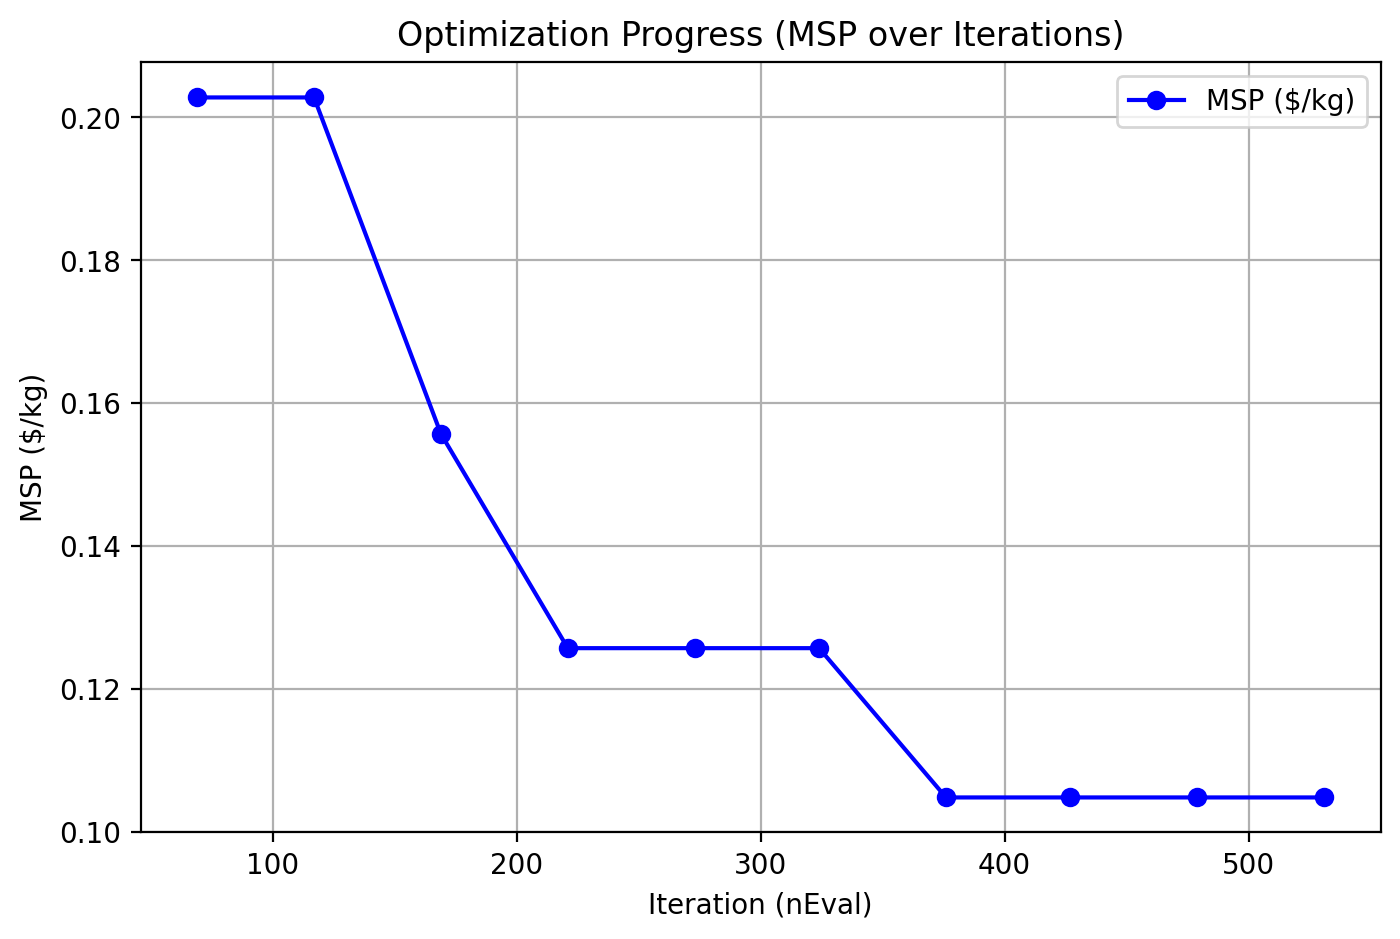

In [2]:

#pdb.set_trace() # left this here incase you need to debug something
# bb = BlackBox(verbose=True)
# results = bb.optimize(maxiter=100) 
# bb.plot_results()

bb = BlackBox(verbose=True)
results_bo = bb.optimize(method='DE', maxiter=10)  # Bayesian Optimization 
bb.plot_results()
